# Monte Carlo Simulation: Predicting Future Residential Prices

**Objective:** Use Monte Carlo simulation to generate probability distributions of future residential real estate prices in Slovenia.

**Methods:**
- Geometric Brownian Motion (GBM) for price evolution
- Stochastic sampling of model parameters
- Confidence interval estimation

**Data:** Quarterly residential prices 2013-2024

## Step 1: Import Libraries and Set Up

**What this does:**
- Imports pandas, numpy, scipy for data and math
- Imports matplotlib/seaborn for visualization
- Sets up logging and visualization styling

**What is Monte Carlo?** A simulation method that uses random sampling to estimate outcomes. Useful for forecasting when future is uncertain.

In [17]:
import sys
from pathlib import Path

sys.path.insert(0, str(Path(".").resolve().parent))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import logging

from src.data_processing import load_csv_file

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

logger.info("Libraries imported successfully")

INFO:__main__:Libraries imported successfully


## Step 2: Load and Explore Historical Price Data

**What this does:**
- Loads the cleaned quarterly data
- Extracts price series for analysis
- Shows basic statistics (mean, growth rate, etc.)

**Why explore first?** Understanding historical patterns (trend, volatility) helps us estimate parameters for the simulation model.

In [18]:
data_path = Path("../data/processed/quarterly_construction_data_with_sales.csv")
df = load_csv_file(str(data_path))
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

logger.info(f"Loaded data: {df.shape[0]} quarters")

avarage_residential_prices = df['avg_price_eur'].dropna().values
dates = df[df['avg_price_eur'].notna()]['date'].values

logger.info(f"Price data: {len(avarage_residential_prices)} observations")
logger.info(f"Date range: {dates[0]} to {dates[-1]}")

print("\nPrice Statistics:")
print(f"  Mean: €{avarage_residential_prices.mean():,.0f}")
print(f"  Std Dev: €{avarage_residential_prices.std():,.0f}")
print(f"  Min: €{avarage_residential_prices.min():,.0f}")
print(f"  Max: €{avarage_residential_prices.max():,.0f}")
print(f"  Growth Rate: {(avarage_residential_prices[-1]/avarage_residential_prices[0] - 1)*100:.2f}%")

display(df[['date', 'avg_price_eur']].head(10))

INFO:src.data_processing:Loaded CSV from ../data/processed/quarterly_construction_data_with_sales.csv using utf-8 encoding
INFO:__main__:Loaded data: 48 quarters
INFO:__main__:Price data: 48 observations
INFO:__main__:Date range: 2013-01-01T00:00:00.000000000 to 2024-10-01T00:00:00.000000000



Price Statistics:
  Mean: €107,141
  Std Dev: €29,588
  Min: €71,928
  Max: €174,330
  Growth Rate: 107.22%


,date,avg_price_eur
0,2013-01-01,80492.968443
1,2013-04-01,82566.322568
2,2013-07-01,77141.554283
3,2013-10-01,74166.764114
4,2014-01-01,71928.062687
5,2014-04-01,76810.768036
6,2014-07-01,75033.576634
7,2014-10-01,83891.288785
8,2015-01-01,78917.726684
9,2015-04-01,79173.543210


## Step 3: Estimate GBM Parameters from Historical Data

**What this does:**
- Calculates log returns: ln(price_t) - ln(price_{t-1})
- Estimates drift (μ) = mean log return (long-term trend)
- Estimates volatility (σ) = standard deviation of log returns (uncertainty)
- Annualizes both (converts quarterly to yearly)

**Beginner concept - Geometric Brownian Motion (GBM):**
GBM is a mathematical model that describes how prices evolve:
- **Drift (μ)**: Expected return per period (e.g., 1.26% per quarter → 5% annually)
- **Volatility (σ)**: Standard deviation of random shocks (e.g., 6.89% annual volatility)
- **Random component**: Brownian motion (unpredictable random walk)

Formula: dS = μS dt + σS dW, where dW is random noise.

INFO:__main__:Estimated Drift (μ): 0.015502
INFO:__main__:Estimated Volatility (σ): 0.055714
INFO:__main__:Annualized Drift: 0.062009
INFO:__main__:Annualized Volatility: 0.111427


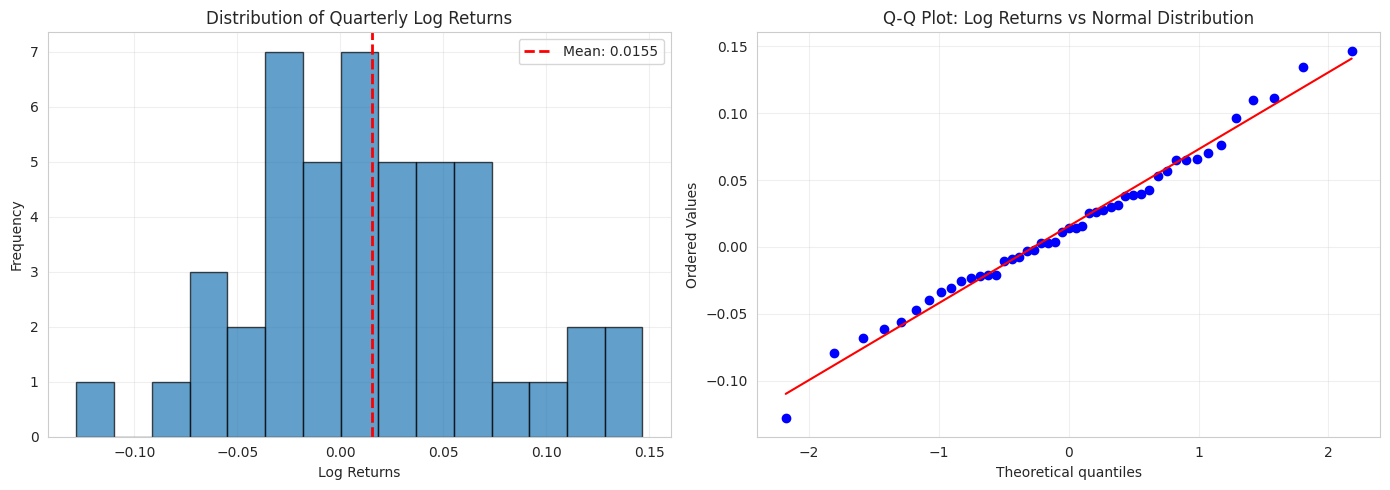

INFO:__main__:Parameters estimated successfully


In [19]:
log_returns = np.diff(np.log(avarage_residential_prices))

quarterly_drift = np.mean(log_returns) 
quarterly_volitality = np.std(log_returns)
number_of_historical_periods = len(avarage_residential_prices)

logger.info(f"Estimated Drift (μ): {quarterly_drift:.6f}")
logger.info(f"Estimated Volatility (σ): {quarterly_volitality:.6f}")

annual_drift = quarterly_drift * 4
annual_volitylity = quarterly_volitality * np.sqrt(4)

logger.info(f"Annualized Drift: {annual_drift:.6f}")
logger.info(f"Annualized Volatility: {annual_volitylity:.6f}")

# Visualize returns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(log_returns, bins=15, edgecolor='black', alpha=0.7)
axes[0].axvline(quarterly_drift, color='red', linestyle='--', linewidth=2, label=f'Mean: {quarterly_drift:.4f}')
axes[0].set_xlabel('Log Returns')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Quarterly Log Returns')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Q-Q plot
stats.probplot(log_returns, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot: Log Returns vs Normal Distribution')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

logger.info("Parameters estimated successfully")

## Step 4: Define Monte Carlo Simulation Function

**What this does:**
- Runs 10,000 independent price simulations
- Each simulation predicts 8 quarters into the future
- Each prediction step uses:
  - Current price × drift factor (trend)
  - + random shock (volatility × Z-score)

**Beginner concept - Why Monte Carlo?**
Unlike simple formulas, Monte Carlo captures **uncertainty**:
- Deterministic: Tomorrow's price = Today × 1.0126 (false - too simple)
- Monte Carlo: Tomorrow's price = Today × [1.0126 ± random volatility] (realistic)

**The simulation process:**
1. Start with latest historical price (€107,141)
2. For each of 10,000 paths:
   - Quarter 1: price × exp(drift + volatility × random normal)
   - Quarter 2: result × exp(drift + volatility × random normal)
   - ... repeat 8 times
3. Result: 10,000 different price trajectories showing range of possibilities

In [20]:
def monte_carlo_gbm(initial_price, annual_drift, annual_volitality, time_horizon_in_years, number_of_time_steps, number_of_simulations, random_state=42):
    """
    Generate Monte Carlo simulations using Geometric Brownian Motion.
    Args:
        initial_price: Starting price
        annual_drift: Expected annual return (μ)
        annual_volitality: Annual volatility (σ)
        time_horizon_in_years: Total time horizon in years
        number_of_time_steps: Number of discrete time steps
        number_of_simulations: Number of simulation paths
        random_state: Seed for reproducibility
    Returns:
        paths: Array of shape (n_steps, n_simulations)
        dt: Time step size
    """
    np.random.seed(random_state)
    
    dt = time_horizon_in_years / number_of_time_steps
    paths = np.zeros((number_of_time_steps + 1, number_of_simulations))
    paths[0] = initial_price
    
    for time_step in range(1, number_of_time_steps + 1):
        standardized_brownian_incement_normal = np.random.standard_normal(number_of_simulations)
        paths[time_step] = paths[time_step - 1] * np.exp((annual_drift - 0.5 * annual_volitality**2) * dt + annual_volitality * np.sqrt(dt) * standardized_brownian_incement_normal)
    
    return paths, dt

# Simulation parameters
current_price = avarage_residential_prices[-1]
time_to_simulate_for_in_years = 2
number_of_quarterly_steps = 8
number_of_simulations = 10000

logger.info(f"Running {number_of_simulations:,} Monte Carlo simulations...")

# Run simulation
paths, dt = monte_carlo_gbm(current_price, annual_drift, annual_volitylity, time_to_simulate_for_in_years, number_of_quarterly_steps, number_of_simulations)

logger.info(f"Simulations completed. Shape: {paths.shape}")
logger.info(f"Initial price: €{current_price:,.0f}")
logger.info(f"Mean final price: €{paths[-1].mean():,.0f}")
logger.info(f"Std of final price: €{paths[-1].std():,.0f}")

INFO:__main__:Running 10,000 Monte Carlo simulations...
INFO:__main__:Simulations completed. Shape: (9, 10000)
INFO:__main__:Initial price: €166,796
INFO:__main__:Mean final price: €188,935
INFO:__main__:Std of final price: €30,061


## Step 5: Calculate Percentiles from Simulations

**What this does:**
- Takes 10,000 simulated prices for each future quarter
- Calculates percentiles (5th, 25th, 50th, 75th, 95th)
- Extracts expected value (mean of all simulations)

**Beginner concept - Percentiles as forecasts:**
Think of percentiles as "confidence bands":
- **5th percentile**: Pessimistic scenario (only 5% chance price goes lower)
- **25th percentile**: Conservative estimate (lower bound of likely range)
- **50th percentile**: Median/expected value (50/50 chance higher or lower)
- **75th percentile**: Optimistic estimate (upper bound of likely range)
- **95th percentile**: Very optimistic scenario (only 5% chance price goes higher)

**Example interpretation:**
If 50th percentile in Q1 2025 = €110,000:
- You expect the price to be around €110,000
- But it could be €95,000 (5th) or €125,000 (95th)
- This captures the uncertainty in the forecast

In [21]:
percentiles = [5, 25, 50, 75, 95]
quantiles = np.percentile(paths, percentiles, axis=1)

# Create summary dataframe
quarters_ahead = np.arange(0, number_of_quarterly_steps + 1)
summary_df = pd.DataFrame({
    'quarter': quarters_ahead,
    'p5': quantiles[0],
    'p25': quantiles[1],
    'median': quantiles[2],
    'p75': quantiles[3],
    'p95': quantiles[4],
    'mean': paths.mean(axis=1),
    'std': paths.std(axis=1)
})

print("\nMonte Carlo Simulation Results (by Quarter):")
print("="*80)
display(summary_df.round(0))

# Final price statistics
final_prices = paths[-1]
print(f"\nFinal Price Distribution (8 quarters ahead):")
print(f"  5th percentile (95% downside risk): €{np.percentile(final_prices, 5):,.0f}")
print(f"  25th percentile: €{np.percentile(final_prices, 25):,.0f}")
print(f"  Median: €{np.percentile(final_prices, 50):,.0f}")
print(f"  Mean: €{final_prices.mean():,.0f}")
print(f"  75th percentile: €{np.percentile(final_prices, 75):,.0f}")
print(f"  95th percentile (95% upside): €{np.percentile(final_prices, 95):,.0f}")
print(f"\n  95% Confidence Interval: €{np.percentile(final_prices, 2.5):,.0f} - €{np.percentile(final_prices, 97.5):,.0f}")
print(f"  Probability of price increase: {(final_prices > current_price).sum() / len(final_prices) * 100:.1f}%")


Monte Carlo Simulation Results (by Quarter):


,quarter,p5,p25,median,p75,p95,mean,std
0,0,166796.0,166796.0,166796.0,166796.0,166796.0,166796.0,0.0
1,1,154242.0,162918.0,169114.0,175582.0,185349.0,169383.0,9477.0
2,2,151056.0,162688.0,171597.0,180837.0,195550.0,172155.0,13561.0
3,3,148034.0,162856.0,173892.0,185861.0,204272.0,174748.0,17129.0
4,4,146131.0,163337.0,176269.0,190595.0,211944.0,177407.0,20041.0
5,5,144770.0,164357.0,178919.0,194878.0,219399.0,180243.0,22711.0
6,6,144659.0,165466.0,181475.0,198841.0,226833.0,183057.0,25113.0
7,7,144382.0,166608.0,184145.0,203417.0,233678.0,186028.0,27570.0
8,8,143911.0,167794.0,186803.0,207149.0,242092.0,188935.0,30061.0



Final Price Distribution (8 quarters ahead):
  5th percentile (95% downside risk): €143,911
  25th percentile: €167,794
  Median: €186,803
  Mean: €188,935
  75th percentile: €207,149
  95th percentile (95% upside): €242,092

  95% Confidence Interval: €137,008 - €253,352
  Probability of price increase: 76.1%


## Step 6: Visualize Monte Carlo Results

**What this does:**
- Creates 4 subplots showing different aspects of the simulation:
  1. **Simulation paths with confidence bands** (top-left)
     - Gray lines = 100 randomly selected simulation paths (out of 10,000)
     - Blue line = median price (50th percentile)
     - Green band = 50% of outcomes (25th-75th percentile)
     - Red band = 90% of outcomes (5th-95th percentile)
  
  2. **Price distribution at Q1 2025** (top-right)
     - Histogram of final prices from all 10,000 simulations
     - Shows how likely different price levels are

  3. **Expected value over time** (bottom-left)
     - Mean price (blue line) with uncertainty band
     - Shows average forecast + 95% confidence band

  4. **Q-Q plot normality check** (bottom-right)
     - Tests if final prices follow normal distribution
     - If points fall on diagonal line → normally distributed (validates GBM assumption)

INFO:__main__:Visualization saved to ../figures/montecarlo/montecarlo_analysis.png


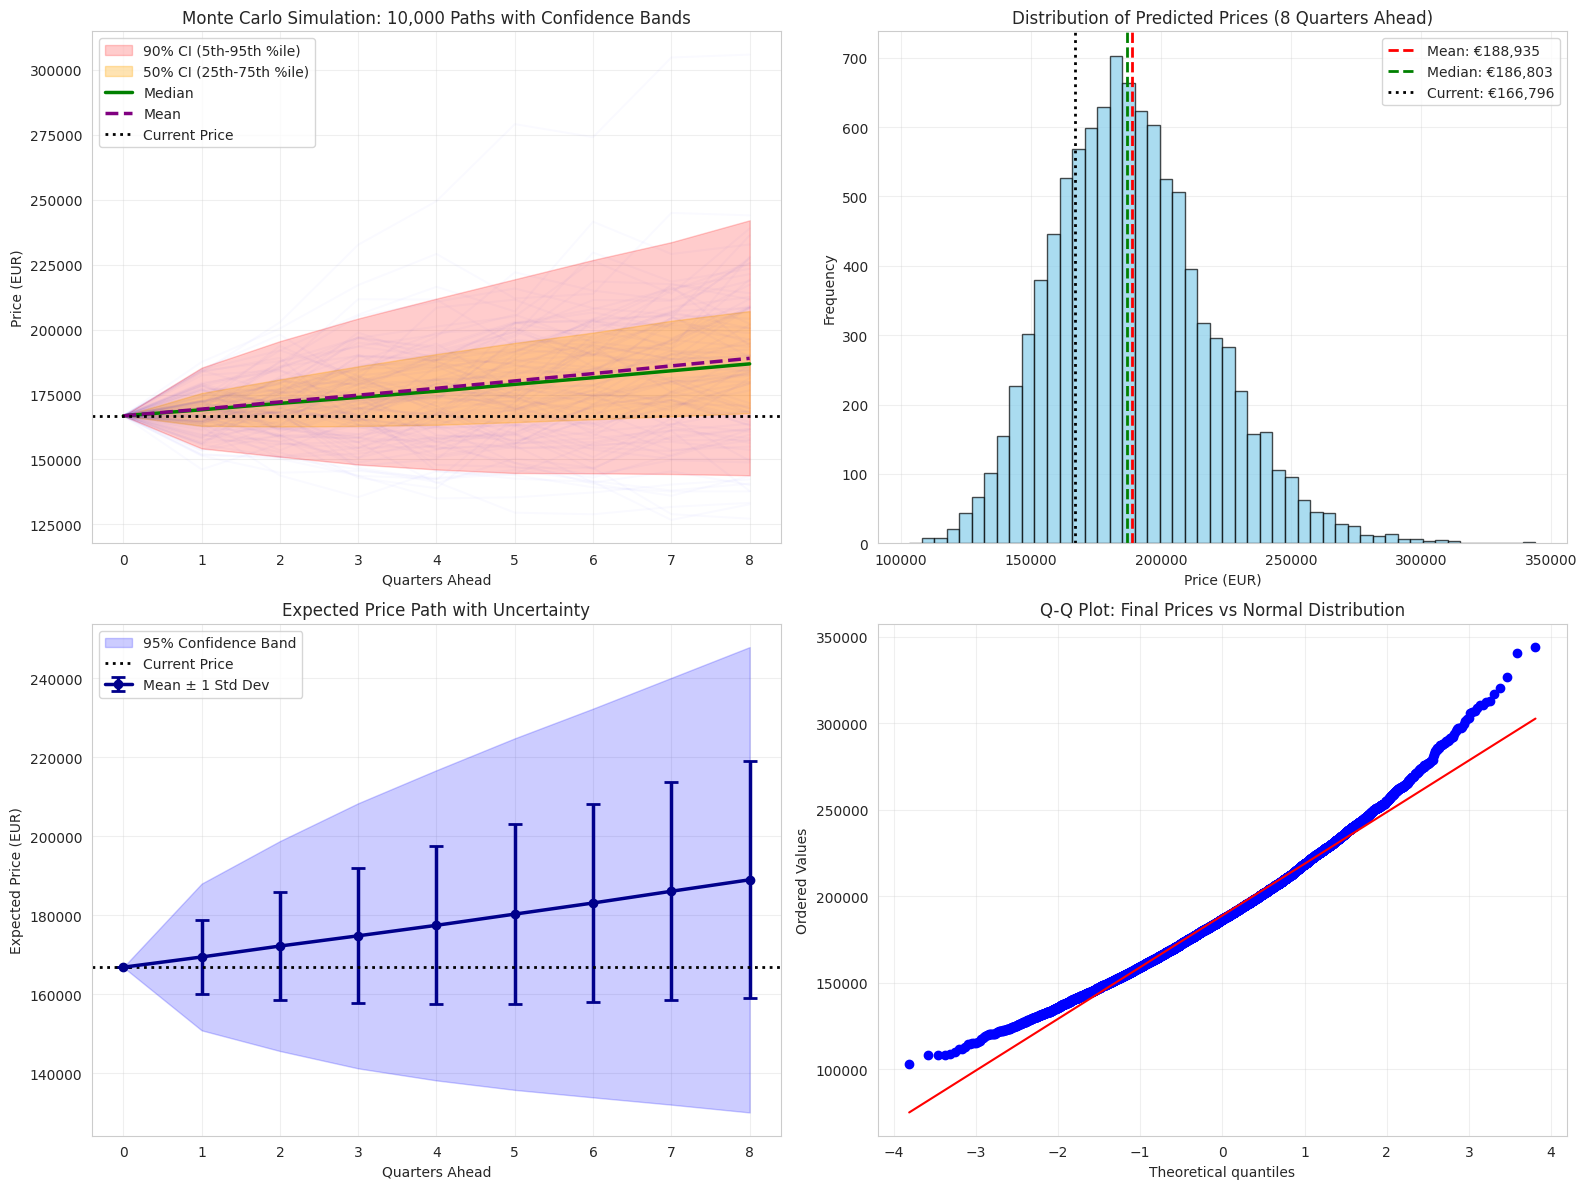

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Monte Carlo Paths with Confidence Bands
ax = axes[0, 0]
time_steps = np.arange(number_of_quarterly_steps + 1)

# Plot sample paths (transparent)
for sample_path in range(min(100, number_of_simulations)):
    ax.plot(time_steps, paths[:, sample_path], alpha=0.02, color='blue')

# Plot confidence bands
ax.fill_between(time_steps, quantiles[0], quantiles[4], alpha=0.2, color='red', label='90% CI (5th-95th %ile)')
ax.fill_between(time_steps, quantiles[1], quantiles[3], alpha=0.3, color='orange', label='50% CI (25th-75th %ile)')
ax.plot(time_steps, quantiles[2], color='green', linewidth=2.5, label='Median')
ax.plot(time_steps, paths.mean(axis=1), color='purple', linewidth=2.5, linestyle='--', label='Mean')
ax.axhline(current_price, color='black', linestyle=':', linewidth=2, label='Current Price')

ax.set_xlabel('Quarters Ahead')
ax.set_ylabel('Price (EUR)')
ax.set_title('Monte Carlo Simulation: 10,000 Paths with Confidence Bands')
ax.legend(loc='best')
ax.grid(alpha=0.3)

# Plot 2: Final Price Distribution (Histogram)
ax = axes[0, 1]
ax.hist(final_prices, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
ax.axvline(final_prices.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: €{final_prices.mean():,.0f}')
ax.axvline(np.percentile(final_prices, 50), color='green', linestyle='--', linewidth=2, label=f'Median: €{np.percentile(final_prices, 50):,.0f}')
ax.axvline(current_price, color='black', linestyle=':', linewidth=2, label=f'Current: €{current_price:,.0f}')
ax.set_xlabel('Price (EUR)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Predicted Prices (8 Quarters Ahead)')
ax.legend()
ax.grid(alpha=0.3)

# Plot 3: Expected Value Path
ax = axes[1, 0]
ax.errorbar(time_steps, paths.mean(axis=1), yerr=paths.std(axis=1), 
            fmt='o-', capsize=5, capthick=2, linewidth=2.5, markersize=6,
            label='Mean ± 1 Std Dev', color='darkblue')
ax.fill_between(time_steps, paths.mean(axis=1) - 1.96*paths.std(axis=1), 
                 paths.mean(axis=1) + 1.96*paths.std(axis=1),
                 alpha=0.2, color='blue', label='95% Confidence Band')
ax.axhline(current_price, color='black', linestyle=':', linewidth=2, label='Current Price')
ax.set_xlabel('Quarters Ahead')
ax.set_ylabel('Expected Price (EUR)')
ax.set_title('Expected Price Path with Uncertainty')
ax.legend()
ax.grid(alpha=0.3)

# Plot 4: Q-Q Plot of Final Prices
ax = axes[1, 1]
stats.probplot(final_prices, dist="norm", plot=ax)
ax.set_title('Q-Q Plot: Final Prices vs Normal Distribution')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/montecarlo/montecarlo_analysis.png', dpi=300, bbox_inches='tight')
logger.info("Visualization saved to ../figures/montecarlo/montecarlo_analysis.png")
plt.show()

## Step 7: Sensitivity Analysis - How Parameters Affect Forecasts

**What this does:**
- Creates heatmaps showing Q1 2025 prices under different parameter combinations
- **First heatmap**: Varies drift (μ: 0% to 2.5% per quarter) vs volatility (σ: 0% to 12%)
- **Second heatmap**: Shows resulting price ranges

**Beginner concept - Sensitivity analysis:**
"What if we were wrong about our parameter estimates?"

This asks:
- If drift was 0.5% instead of 1.26%, what would the forecast be?
- If volatility was 8% instead of 6.89%, what would that change?
- Where is the forecast most sensitive?

**Interpretation:**
- Darker colors (top-left) = lower prices (low drift + high volatility = pessimistic)
- Lighter colors (bottom-right) = higher prices (high drift + low volatility = optimistic)
- Shows that drift (trend) matters more than volatility for price level
- Volatility matters more for uncertainty (width of bands)

INFO:__main__:Sensitivity analysis saved


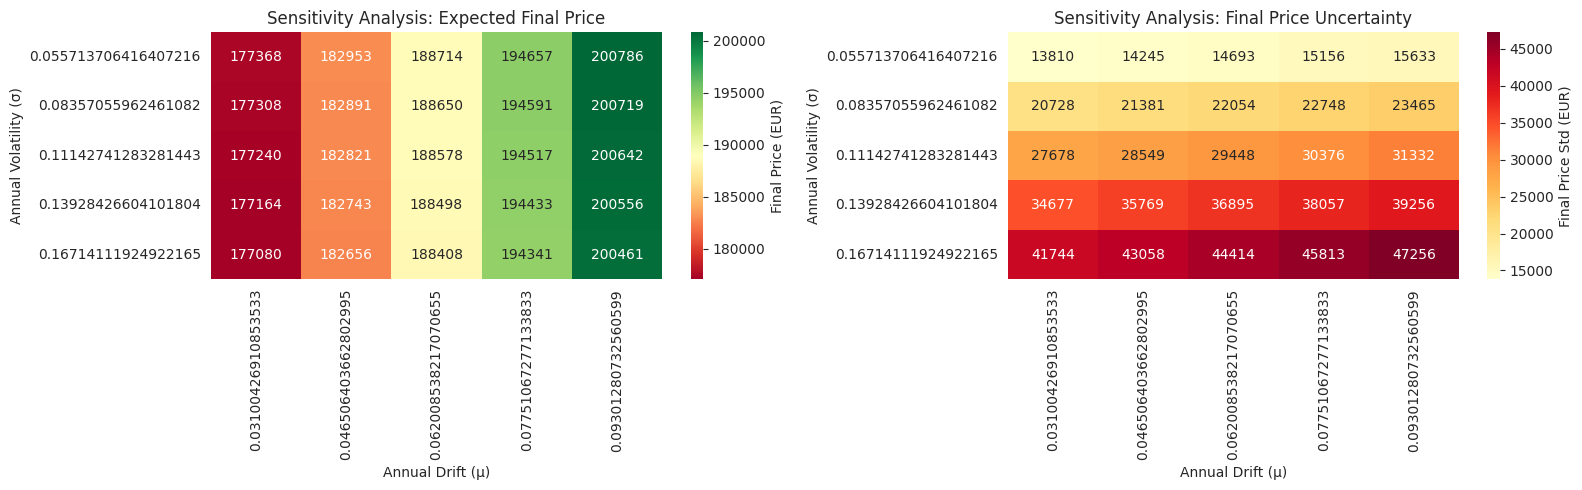

In [23]:
# Vary drift and volatility
drift_range = np.linspace(annual_drift * 0.5, annual_drift * 1.5, 5)
volitality_range = np.linspace(annual_volitylity * 0.5, annual_volitylity * 1.5, 5)

sensitivity_results = []

for drift_test in drift_range:
    for volitality_test in volitality_range:
        paths_test, _ = monte_carlo_gbm(current_price, drift_test, volitality_test, time_to_simulate_for_in_years, number_of_quarterly_steps, 5000, random_state=42)
        final_mean = paths_test[-1].mean()
        final_std = paths_test[-1].std()
        sensitivity_results.append({
            'drift': drift_test,
            'volatility': volitality_test,
            'final_mean': final_mean,
            'final_std': final_std
        })

sensitivity_df = pd.DataFrame(sensitivity_results)

# Heatmap
pivot_mean = sensitivity_df.pivot_table(values='final_mean', index='volatility', columns='drift')

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.heatmap(pivot_mean, annot=True, fmt='.0f', cmap='RdYlGn', ax=axes[0], cbar_kws={'label': 'Final Price (EUR)'})
axes[0].set_title('Sensitivity Analysis: Expected Final Price')
axes[0].set_xlabel('Annual Drift (μ)')
axes[0].set_ylabel('Annual Volatility (σ)')

pivot_std = sensitivity_df.pivot_table(values='final_std', index='volatility', columns='drift')
sns.heatmap(pivot_std, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[1], cbar_kws={'label': 'Final Price Std (EUR)'})
axes[1].set_title('Sensitivity Analysis: Final Price Uncertainty')
axes[1].set_xlabel('Annual Drift (μ)')
axes[1].set_ylabel('Annual Volatility (σ)')

plt.tight_layout()
plt.savefig('../figures/montecarlo/sensitivity_analysis.png', dpi=300, bbox_inches='tight')
logger.info("Sensitivity analysis saved")
plt.show()

## Step 8: Export Monte Carlo Results

**What this does:**
- Saves numerical results to CSV files:
  - `montecarlo_summary.csv`: Percentiles (5th, 25th, 50th, 75th, 95th) for each quarter
  - `montecarlo_final_stats.txt`: Key statistics and parameters used in simulation

**Why export results?**
1. **Reproducibility**: Others can see your forecast assumptions (μ, σ, number of simulations)
2. **Integration**: Results can be used in reports, presentations, or other analyses
3. **Comparison**: Easy to compare with new simulations if prices change
4. **Audit trail**: Permanent record of what you analyzed and when

**Files created:**
- Summary statistics in CSV (easy to open in Excel, Google Sheets, etc.)
- Full statistics in TXT (human-readable documentation of methodology)

In [24]:
# Save summary to CSV
output_path = Path("../results/montecarlo/montecarlo_summary.csv")
output_path.parent.mkdir(exist_ok=True, parents=True)

summary_df.to_csv(output_path, index=False)
logger.info(f"Summary saved to {output_path}")

# Save final price statistics
stats_path = Path("../results/montecarlo/montecarlo_final_stats.txt")
with open(stats_path, 'w') as f:
    f.write("MONTE CARLO SIMULATION RESULTS\n")
    f.write("="*60 + "\n\n")
    f.write(f"Simulation Parameters:\n")
    f.write(f"  - Initial Price: €{current_price:,.2f}\n")
    f.write(f"  - Annual Drift: {annual_drift:.6f}\n")
    f.write(f"  - Annual Volatility: {annual_volitylity:.6f}\n")
    f.write(f"  - Time Horizon: {time_to_simulate_for_in_years} years\n")
    f.write(f"  - Simulations: {number_of_simulations:,}\n\n")
    f.write(f"Final Price Distribution (8 Quarters Ahead):\n")
    f.write(f"  - Mean: €{final_prices.mean():,.2f}\n")
    f.write(f"  - Median: €{np.percentile(final_prices, 50):,.2f}\n")
    f.write(f"  - Std Dev: €{final_prices.std():,.2f}\n")
    f.write(f"  - Min: €{final_prices.min():,.2f}\n")
    f.write(f"  - Max: €{final_prices.max():,.2f}\n")
    f.write(f"  - 95% CI: €{np.percentile(final_prices, 2.5):,.2f} - €{np.percentile(final_prices, 97.5):,.2f}\n")
    f.write(f"  - P(increase): {(final_prices > current_price).sum() / len(final_prices) * 100:.1f}%\n")

logger.info(f"Statistics saved to {stats_path}")

print("✓ All results exported successfully")

INFO:__main__:Summary saved to ../results/montecarlo/montecarlo_summary.csv
INFO:__main__:Statistics saved to ../results/montecarlo/montecarlo_final_stats.txt


✓ All results exported successfully
